<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/preprocessing_and_model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [82]:
class g:
  window_size = 8
  batch_size = 16

In [83]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [84]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [85]:
data.drop(columns = 'index_membership', inplace = True)

In [86]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data

,date,identifier,market_cap,sector,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,35,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,0.792736,-0.000005,0.109029,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,35,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,0.333230,-0.009504,0.121348,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,35,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,0.058918,-0.000099,0.890898,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,35,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,0.699718,-0.000037,0.355059,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,35,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,0.961276,0.000163,0.196711,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,25,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,0.308049,0.012255,0.281193,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,25,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,0.559633,0.001058,0.755124,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,25,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,0.591153,0.000054,0.933679,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,25,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,0.373209,-0.000411,0.225972,-0.000242


In [87]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [88]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [89]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [90]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values > 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.052423
15    0.093655
20    0.212044
25    0.126521
30    0.076618
35    0.045433
40    0.228443
45    0.052423
50    0.039048
55    0.073392
dtype: float64

In [91]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values <= 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.010229
15    0.087152
20    0.165712
25    0.209902
30    0.025777
35    0.092471
40    0.286007
45    0.042553
50    0.029869
55    0.050327
dtype: float64

In [92]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
sector_onehot

,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55
82,0,0,0,0,0,1,0,0,0,0
400,0,0,0,0,0,1,0,0,0,0
718,0,0,0,0,0,1,0,0,0,0
1036,0,0,0,0,0,1,0,0,0,0
1354,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
12552,0,0,0,1,0,0,0,0,0,0
12862,0,0,0,1,0,0,0,0,0,0
13172,0,0,0,1,0,0,0,0,0,0
13483,0,0,0,1,0,0,0,0,0,0


In [93]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,...,0,0,0,0,1,0,0,0,0,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,...,0,0,0,0,1,0,0,0,0,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,...,0,0,0,0,1,0,0,0,0,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,...,0,0,0,0,1,0,0,0,0,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,...,0,0,0,0,1,0,0,0,0,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,...,0,0,1,0,0,0,0,0,0,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,...,0,0,1,0,0,0,0,0,0,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,...,0,0,1,0,0,0,0,0,0,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,...,0,0,1,0,0,0,0,0,0,-0.000242


In [94]:
import math
from math import floor as fl
ident_counts= data.value_counts('identifier')
def split_to_series(df, valid_size = .1, test_size = .05,length_cutoff = 3*g.window_size):
  ident_counts= df.value_counts('identifier')
  df_long = df[df['identifier'].isin(list(ident_counts[ident_counts.values > length_cutoff].index))]
  df_short = df[df['identifier'].isin(list(ident_counts[(ident_counts.values <= length_cutoff) & (ident_counts.values >= 2*g.window_size)].index))]
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {}
  for i, ident in enumerate(df_long.value_counts('identifier').index):
    series_dict[i] = df_long[df_long['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
    train_dict[i] = series_dict[i].iloc[:fl((1-valid_size - test_size)*len(series_dict[i])) - 2*g.window_size]
    valid_dict[i] = series_dict[i].iloc[fl((1-valid_size - test_size)*len(series_dict[i]))- 2*g.window_size:fl((1- test_size)*len(series_dict[i]))- g.window_size]
    test_dict[i] = series_dict[i].iloc[fl((1- test_size)*len(series_dict[i]))- g.window_size:]
  for j, ident in enumerate(df_short.value_counts('identifier').index):
    train_dict[len(series_dict)+j] = df_short[df_short['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
  print(f"Number of time series to be trained and tested: {len([keys for keys in series_dict])}")
  print(f"Number of time series to be trained: {len([keys for keys in train_dict])}")
  return train_dict, valid_dict, test_dict

In [95]:
train_dict, valid_dict, test_dict = split_to_series(data)

Number of time series to be trained and tested: 331
Number of time series to be trained: 339


In [96]:
train_dict[294]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
0,2010-08-11,FMOHK7CPCLT3,2.848643e+09,0.798835,-0.000106,0.166318,0.408212,0.077306,0.540514,0.036312,...,0,0,0,0,0,1,0,0,0,-0.000083
1,2010-08-18,FMOHK7CPCLT3,8.968599e+08,0.214806,-0.000770,0.660014,0.904780,0.788543,0.824618,0.383134,...,0,0,0,0,0,1,0,0,0,-0.001152
2,2010-08-25,FMOHK7CPCLT3,1.622673e+09,0.381020,0.036322,0.361238,0.509406,0.513737,0.088438,0.597968,...,0,0,0,0,0,1,0,0,0,0.021944
3,2010-09-01,FMOHK7CPCLT3,3.533210e+09,0.164807,0.000647,0.011318,0.502661,0.320518,0.654605,0.161958,...,0,0,0,0,0,1,0,0,0,0.002250
4,2010-09-08,FMOHK7CPCLT3,1.563805e+09,0.274727,0.010258,0.784380,0.291993,0.903812,0.167277,0.316741,...,0,0,0,0,0,1,0,0,0,0.006687
5,2010-09-15,FMOHK7CPCLT3,1.312669e+09,0.034010,0.000218,0.287906,0.068714,0.363024,0.549292,0.910582,...,0,0,0,0,0,1,0,0,0,0.000112
6,2010-09-22,FMOHK7CPCLT3,2.780770e+09,0.989591,-0.003323,0.205294,0.527446,0.137298,0.175086,0.913233,...,0,0,0,0,0,1,0,0,0,-0.003449
7,2010-09-29,FMOHK7CPCLT3,3.154707e+09,0.257527,-0.002062,0.500003,0.290278,0.700611,0.599164,0.148275,...,0,0,0,0,0,1,0,0,0,-0.001729
8,2010-10-06,FMOHK7CPCLT3,3.255331e+09,0.253269,-0.000536,0.612562,0.862434,0.692755,0.495828,0.787133,...,0,0,0,0,0,1,0,0,0,-0.000663
9,2010-10-13,FMOHK7CPCLT3,2.660440e+09,0.959284,-0.000088,0.198665,0.430492,0.704453,0.384669,0.352189,...,0,0,0,0,0,1,0,0,0,-0.000101


In [97]:
valid_dict[294]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
39,2011-05-11,FMOHK7CPCLT3,1.613963e+09,0.406265,-0.010637,0.895419,0.514021,0.692768,0.165175,0.746287,...,0,0,0,0,0,1,0,0,0,-0.002942
40,2011-05-18,FMOHK7CPCLT3,1.509619e+09,0.272737,-0.000011,0.858708,0.809688,0.492886,0.127629,0.342394,...,0,0,0,0,0,1,0,0,0,-0.000007
41,2011-05-25,FMOHK7CPCLT3,1.152360e+09,0.610906,0.000000,0.814717,0.460878,0.284146,0.092294,0.493794,...,0,0,0,0,0,1,0,0,0,0.000000
42,2011-06-01,FMOHK7CPCLT3,1.295900e+09,0.772408,-0.000154,0.094250,0.631536,0.174941,0.384043,0.092641,...,0,0,0,0,0,1,0,0,0,-0.000170
43,2011-06-08,FMOHK7CPCLT3,1.969514e+09,0.597463,-0.016755,0.252485,0.078943,0.681970,0.144649,0.611581,...,0,0,0,0,0,1,0,0,0,-0.007673
44,2011-06-15,FMOHK7CPCLT3,2.851247e+08,0.474382,-0.005034,0.482968,0.752567,0.966634,0.362801,0.141626,...,0,0,0,0,0,1,0,0,0,-0.005364
45,2011-06-22,FMOHK7CPCLT3,9.525177e+08,0.013793,-0.000045,0.924826,0.014213,0.277240,0.289064,0.150890,...,0,0,0,0,0,1,0,0,0,-0.000052
46,2011-06-29,FMOHK7CPCLT3,4.894687e+08,0.011589,-0.001354,0.836333,0.019921,0.929111,0.161085,0.195178,...,0,0,0,0,0,1,0,0,0,-0.003211
47,2011-07-06,FMOHK7CPCLT3,8.228107e+08,0.324533,-0.000682,0.055669,0.096428,0.675421,0.000487,0.201670,...,0,0,0,0,0,1,0,0,0,-0.000496
48,2011-07-13,FMOHK7CPCLT3,9.606088e+08,0.575096,-0.000360,0.854678,0.558345,0.335224,0.728194,0.658082,...,0,0,0,0,0,1,0,0,0,-0.000174


In [98]:
test_dict[294]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
53,2011-08-17,FMOHK7CPCLT3,1.604163e+09,0.813080,-0.049838,0.660901,0.082820,0.901585,0.470561,0.201076,...,0,0,0,0,0,1,0,0,0,-0.018123
54,2011-08-24,FMOHK7CPCLT3,8.227858e+08,0.052590,-0.002174,0.490832,0.826541,0.307415,0.755374,0.097706,...,0,0,0,0,0,1,0,0,0,-0.002544
55,2011-08-31,FMOHK7CPCLT3,4.608562e+08,0.624169,-0.003309,0.264708,0.607009,0.561201,0.698628,0.574065,...,0,0,0,0,0,1,0,0,0,-0.003354
56,2011-09-07,FMOHK7CPCLT3,5.077954e+08,0.404445,-0.000060,0.931153,0.812701,0.188711,0.158023,0.407141,...,0,0,0,0,0,1,0,0,0,-0.000542
57,2011-09-14,FMOHK7CPCLT3,6.029857e+07,0.415991,-0.000003,0.614012,0.985945,0.807151,0.651730,0.111509,...,0,0,0,0,0,1,0,0,0,-0.000010
58,2011-09-21,FMOHK7CPCLT3,6.979467e+08,0.156538,-0.000004,0.465729,0.862046,0.744514,0.482762,0.460736,...,0,0,0,0,0,1,0,0,0,-0.000005
59,2011-09-28,FMOHK7CPCLT3,3.198851e+08,0.667625,0.000082,0.965421,0.326623,0.186846,0.348566,0.926864,...,0,0,0,0,0,1,0,0,0,0.000055
60,2011-10-05,FMOHK7CPCLT3,2.112145e+08,0.509527,0.001553,0.123601,0.194378,0.521157,0.055854,0.127391,...,0,0,0,0,0,1,0,0,0,0.000891
61,2011-10-12,FMOHK7CPCLT3,1.145880e+09,0.571968,-0.005306,0.133722,0.694382,0.064742,0.014191,0.644126,...,0,0,0,0,0,1,0,0,0,-0.001746
62,2011-10-19,FMOHK7CPCLT3,6.240339e+08,0.426114,-0.001223,0.442394,0.377937,0.119591,0.985010,0.776674,...,0,0,0,0,0,1,0,0,0,-0.001580


In [99]:
numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10']

In [100]:
def preprocess(train_dict, valid_dict, test_dict, numerical_features):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features])
  t_std = np.std(train_df[numerical_features])
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std

  return train_dict, valid_dict, test_dict


In [101]:
train_scaled, valid_scaled, test_scaled = preprocess(train_dict, valid_dict, test_dict, numerical_features)

In [102]:
train_scaled[0]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
0,2010-01-06,AD41WBQFVG43,2.877332,0.921069,-0.043098,1.159976,0.003184,-1.061088,-0.886646,0.887815,...,0,0,0,0,1,0,0,0,0,-0.000006
1,2010-01-13,AD41WBQFVG43,2.212640,1.406296,-4.704516,-0.523708,0.284077,0.511038,1.294531,0.782325,...,0,0,0,0,1,0,0,0,0,-0.008721
2,2010-01-20,AD41WBQFVG43,1.364788,-0.079570,-0.059715,0.327696,-0.415492,1.072443,-1.682022,0.419427,...,0,0,0,0,1,0,0,0,0,-0.000081
3,2010-01-27,AD41WBQFVG43,2.304236,-0.808306,-0.043452,0.082105,0.633251,0.161593,-1.200734,-1.496849,...,0,0,0,0,1,0,0,0,0,-0.000018
4,2010-02-03,AD41WBQFVG43,0.969338,-0.260537,0.003507,1.567975,0.446332,1.574585,-0.257788,0.884670,...,0,0,0,0,1,0,0,0,0,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2011-04-20,AD41WBQFVG43,3.070243,-0.624454,-0.027959,-1.150029,-1.549021,1.629866,-0.291167,0.542785,...,0,0,0,0,1,0,0,0,0,0.000055
68,2011-04-27,AD41WBQFVG43,1.902638,0.493737,-0.036856,1.645212,-0.746914,-1.393398,-0.710311,-0.683257,...,0,0,0,0,1,0,0,0,0,-0.000011
69,2011-05-04,AD41WBQFVG43,0.944957,-0.709339,-0.082636,-1.517489,-0.294331,-1.204468,-1.220560,1.595627,...,0,0,0,0,1,0,0,0,0,-0.000084
70,2011-05-11,AD41WBQFVG43,2.064631,-0.649902,-0.671639,-0.391335,-1.447296,-0.791861,1.339473,-0.244476,...,0,0,0,0,1,0,0,0,0,-0.009927


In [103]:
valid_scaled[0]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
72,2011-05-25,AD41WBQFVG43,1.802609,0.560933,0.780356,0.962631,0.762203,0.574268,0.461779,-1.365052,...,0,0,0,0,1,0,0,0,0,0.002994
73,2011-06-01,AD41WBQFVG43,1.643892,1.155420,-0.199619,-1.451153,0.063632,1.216239,-0.904808,0.217858,...,0,0,0,0,1,0,0,0,0,-0.002169
74,2011-06-08,AD41WBQFVG43,2.833501,-0.755184,-0.004197,0.228451,-0.359736,1.441092,1.278363,-0.187735,...,0,0,0,0,1,0,0,0,0,0.000700
75,2011-06-15,AD41WBQFVG43,3.174492,0.172864,-0.038757,0.371757,1.230699,-1.036347,-0.518142,0.689538,...,0,0,0,0,1,0,0,0,0,-0.000006
76,2011-06-22,AD41WBQFVG43,2.163958,1.580218,-0.158384,-1.395628,-0.589000,-1.156651,-0.769859,1.378711,...,0,0,0,0,1,0,0,0,0,-0.000579
77,2011-06-29,AD41WBQFVG43,2.965458,-0.186125,0.225054,-1.388665,0.114110,0.316904,1.414483,-1.435913,...,0,0,0,0,1,0,0,0,0,0.000338
78,2011-07-06,AD41WBQFVG43,3.429481,-0.993821,-0.054920,0.555808,0.340983,1.019601,1.336716,-0.328217,...,0,0,0,0,1,0,0,0,0,-0.003415
79,2011-07-13,AD41WBQFVG43,1.366409,1.684122,-0.049359,-1.718960,1.602827,0.697038,-1.257013,1.655672,...,0,0,0,0,1,0,0,0,0,-0.000197
80,2011-07-20,AD41WBQFVG43,2.105564,-0.970464,-1.092992,-0.036310,-0.182915,-0.710924,1.523046,0.049235,...,0,0,0,0,1,0,0,0,0,-0.007665
81,2011-07-27,AD41WBQFVG43,2.080937,0.987377,-0.572930,-1.559946,0.331276,1.086927,-0.229324,0.721965,...,0,0,0,0,1,0,0,0,0,-0.002870


In [104]:
test_scaled[0]

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
90,2011-09-28,AD41WBQFVG43,1.590656,-0.477515,0.254152,-1.155218,1.209329,-1.318391,1.628659,-1.545261,...,0,0,0,0,1,0,0,0,0,0.007584
91,2011-10-05,AD41WBQFVG43,1.141237,1.622209,1.784764,-0.720812,0.992454,0.316789,-1.417923,-0.115184,...,0,0,0,0,1,0,0,0,0,0.003847
92,2011-10-12,AD41WBQFVG43,2.520157,0.526548,0.012644,0.824513,-0.987944,-0.098447,0.594118,-0.264213,...,0,0,0,0,1,0,0,0,0,0.000241
93,2011-10-19,AD41WBQFVG43,1.260228,0.707216,-0.013588,0.371809,-1.269664,0.630502,-0.811981,0.593789,...,0,0,0,0,1,0,0,0,0,0.000285
94,2011-10-26,AD41WBQFVG43,1.290237,-0.151598,-0.306641,-0.443944,0.311171,-0.792742,-1.400344,-1.555968,...,0,0,0,0,1,0,0,0,0,-0.001549
95,2011-11-02,AD41WBQFVG43,2.714305,0.179259,-0.024468,0.819282,1.298059,-1.504118,1.313307,0.857985,...,0,0,0,0,1,0,0,0,0,0.005559
96,2011-11-09,AD41WBQFVG43,2.231927,1.152144,-0.034073,-0.283000,0.691497,0.666868,-0.381691,1.541368,...,0,0,0,0,1,0,0,0,0,0.000127
97,2011-11-16,AD41WBQFVG43,2.723592,1.617163,-0.075084,0.094701,0.988626,0.746851,0.863115,-0.822560,...,0,0,0,0,1,0,0,0,0,-0.000892
98,2011-11-23,AD41WBQFVG43,0.534226,1.020682,-0.021037,-0.012620,-1.592025,-0.092264,1.495839,0.719416,...,0,0,0,0,1,0,0,0,0,0.000106
99,2011-11-30,AD41WBQFVG43,1.179641,1.004694,-0.037998,-0.873221,1.159124,0.033085,-0.561080,-0.523429,...,0,0,0,0,1,0,0,0,0,-0.000004


In [105]:
train_scaled[0].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [106]:
train_scaled[322].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [107]:
def drop_final_columns(data_dict):
  for i in range(0, len(data_dict)):
    data_dict[i].drop(columns = ['date', 'identifier'], inplace = True)
  return data_dict

In [108]:
train_scaled, valid_scaled, test_scaled = \
drop_final_columns(train_scaled), drop_final_columns(valid_scaled), drop_final_columns(test_scaled)

In [109]:
def plot_model_perf(history, metric = None):
  plt.figure(figsize=(12,8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  if metric:
    plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
    plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
    plt.legend()
    plt.show()
  else:
    plt.legend()
    plt.show()

In [110]:
def convert_to_tensor(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[0], dtype= np.float32))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
    for i in range(1, len(data_dict)):
      dataset_tmp = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[i], dtype= np.float32))
      dataset_tmp = dataset_tmp.window(window_size + 1, shift=1, drop_remainder=True)
      dataset_tmp = dataset_tmp.flat_map(lambda window: window.batch(window_size + 1))
      dataset_tmp = dataset_tmp.map(lambda window: (window[:-1], window[-1,-1]))
      dataset = dataset.concatenate(dataset_tmp)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [111]:
train = convert_to_tensor(train_scaled)
valid = convert_to_tensor(valid_scaled)
test = convert_to_tensor(test_scaled)

In [112]:
import tensorflow.keras.backend as K

def smape_loss(y_true, y_pred):
    epsilon = 1e-5
    #summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred) + epsilon) * 2.0
    return smape

In [113]:
tf.keras.backend.clear_session()

def create_time_model(filter_units = 32, lstm_units = 128, kernel_size = 5, dr = .2 ):

    input_ = Input(shape=(None,22))
    #x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
    #                                                          kernel_initializer='he_normal', padding = 'causal')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = Dropout(dr)(x)                                                       
    x = LSTM(lstm_units, return_sequences = True, dropout = dr)(input_)
    x = LSTM(lstm_units, return_sequences = True, dropout = dr)(x)
    #x = LSTM(lstm_units, return_sequences = True, dropout = dr, recurrent_dropout = dr)(x)
    x = TimeDistributed(Dense(100, kernel_initializer="he_normal", activation = 'relu'))(x)
    out = Dense(1)(x)
    #out_L = Lambda(lambda y: y * 1e4)(out)
    model = Model(inputs = input_, outputs = out)

    return model

model = create_time_model()
model.compile(loss = 'mape', optimizer = 'adam', metrics = ['mae', 'mape'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 22)]        0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         77312     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 time_distributed (TimeDistr  (None, None, 100)        12900     
 ibuted)                                                         
                                                                 
 dense_1 (Dense)             (None, None, 1)           101       
                                                                 
Total params: 221,897
Trainable params: 221,897
Non-trainable params: 0
_______________________________________________________

Epoch 1/20
1197/1197 [==============================] - 31s 23ms/step - loss: 71693.0625 - mae: 0.0047 - mape: 71693.0625 - val_loss: 12935.4541 - val_mae: 0.0033 - val_mape: 12935.4541
Epoch 2/20
1197/1197 [==============================] - 30s 24ms/step - loss: 10811.6807 - mae: 0.0021 - mape: 10811.6807 - val_loss: 17931.1484 - val_mae: 0.0040 - val_mape: 17931.1484
Epoch 3/20
1197/1197 [==============================] - 28s 23ms/step - loss: 15088.2090 - mae: 0.0022 - mape: 15088.2090 - val_loss: 13492.5068 - val_mae: 0.0037 - val_mape: 13492.5068
Epoch 4/20
1197/1197 [==============================] - 29s 24ms/step - loss: 9412.6689 - mae: 0.0020 - mape: 9412.6689 - val_loss: 4323.2163 - val_mae: 0.0031 - val_mape: 4323.2163
Epoch 5/20
1197/1197 [==============================] - 29s 24ms/step - loss: 9043.7285 - mae: 0.0020 - mape: 9043.7285 - val_loss: 12342.7158 - val_mae: 0.0036 - val_mape: 12342.7158
Epoch 6/20
1197/1197 [==============================] - 29s 24ms/step - loss

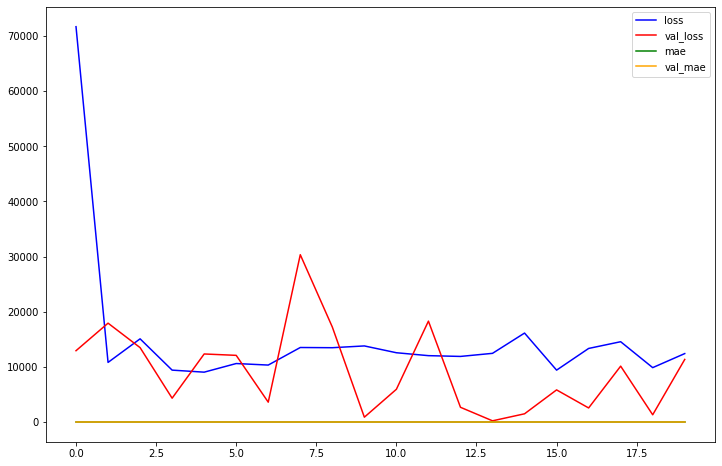

193/193 [==============================] - 16s 14ms/step - loss: 11353.6523 - mae: 0.0036 - mape: 11353.6523


[11353.65234375, 0.003563470207154751, 11353.65234375]

In [114]:

early_stopping = EarlyStopping(patience = 5, restore_best_weights= True)
history = model.fit(train, epochs = 20, validation_data = valid, callbacks = None)
plot_model_perf(history, 'mae')
model.evaluate(valid)

In [115]:
model.evaluate(test)

115/115 [==============================] - 16s 15ms/step - loss: 14050.0107 - mae: 0.0026 - mape: 14050.0107


[14050.0107421875, 0.0026254213880747557, 14050.0107421875]

In [116]:
xbatch, ybatch = iter(test).get_next()

In [120]:
xbatch

<tf.Tensor: shape=(16, 8, 22), dtype=float32, numpy=
array([[[-3.1375417e-01,  4.1164944e-01, -3.8051486e-02, ...,
          0.0000000e+00,  0.0000000e+00, -5.1101313e-07],
        [-3.0738166e-01, -6.0488486e-01,  7.4978739e-02, ...,
          0.0000000e+00,  0.0000000e+00,  1.2507935e-03],
        [-5.0311333e-01, -4.4607535e-02, -5.2114852e-02, ...,
          0.0000000e+00,  0.0000000e+00, -4.3404489e-05],
        ...,
        [-3.5958791e-01,  1.1418343e+00, -1.0601375e+00, ...,
          0.0000000e+00,  0.0000000e+00, -5.6667845e-03],
        [-1.9442196e-01, -1.6261333e+00,  2.6303419e-01, ...,
          0.0000000e+00,  0.0000000e+00,  7.2250131e-04],
        [-3.7372208e-01, -1.1591519e+00, -3.4323152e-02, ...,
          0.0000000e+00,  0.0000000e+00,  1.7170041e-05]],

       [[-6.8328285e-01, -8.5067135e-01, -4.6503801e-02, ...,
          0.0000000e+00,  0.0000000e+00, -5.2909862e-04],
        [-6.3610673e-01, -1.6142564e+00, -5.1897813e-02, ...,
          0.0000000e+00,  0.00

In [119]:
model.predict(xbatch)

array([[[0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525]],

       [[0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525]],

       [[0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525]],

       [[0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525]],

       [[0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525]],

       [[0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],
        [0.00095525],


In [118]:
ybatch

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 9.8665459e-03,  4.5486772e-04,  3.8335625e-06,  1.1434464e-04,
        2.3581074e-03,  8.3727327e-06,  1.8452357e-04, -3.3270533e-04,
        1.7920494e-05,  2.1368824e-03,  3.8737417e-05,  5.3281756e-04,
        7.8549929e-04,  6.0985063e-04, -1.3913432e-04, -8.0406439e-04],
      dtype=float32)>